### 1.0 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import datetime as dt
from math import radians, cos, sin, asin, sqrt #using this for calculating the distance between points

### 2.0 Load Data

Loading in the cleaned, exported data from my data wrangling step.

In [2]:
#load trees data we exported in the prior step
trees_data = pd.read_csv('../data/data_outputs/seattle_trees.csv')

#load climate data we exported in the prior step
climate_data = pd.read_csv('../data/data_outputs/washington_climate_normals.csv')

#### 2.1 Precipitation Data

After testing this out with climate normals data, I only ended up with 3 useful stations for data. So while I was excited to have the 'normals' which is averages over a 15-20 year period, I want to now test pulling in some other data I found.
\
\
The Community Collaborative Rain, Hail, & Snow Network has some great tools to access data. Unfortunately, it is only for the 2022 calendar year. I don't love that, but I think it will give me more useful datapoints to and make the analysis more valuable.
\
\
When pulling this data, I filtered down to all available weather stations in King County, Washington, which includes the Seattle proper.
\
\
https://merbgai.cocorahs.org/Stations/ListStations.aspx

In [3]:
prcp_22 = pd.read_excel('../data/precip_2022.xlsx', sheet_name=0)
print(prcp_22.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB
None


In [4]:
prcp_22.head(3)

,Station Number,Station Name,Daily Precipitation Sum MM,Multi-Day Precipitation mm,Total Precipitation mm,Daily Snow Sum cm,# of Reports,Latitude,Longitude,Multi-Day Overlap Warning
0,WA-KG-3,Lake Forest Park 0.4 W,1111.2,NaN,1111.2,0.0,365,47.763558,-122.293917,NaN
1,WA-KG-4,Renton 3.2 E,149.1,NaN,149.1,0.0,21,47.484508,-122.127169,NaN
2,WA-KG-5,Mercer Island 1.5 NW,1043.4,NaN,1043.4,8.4,365,47.585900,-122.250900,NaN


**Observations**
\
\
The 'Total Precipitation mm' column should be the combination of the dailiy and multi-day column and the field we use. There is no multi-day column for snow, so that will be the column we can use for snow data.
\
\
I will need to confirm latitude & longitude data is complete. I also want to do some renaming of columns to make them a little more straight forward. So far what I've seen from the data, I don't need to worry about the multi-day 'warning', as I believe it is cumulative and not duplicative. I also think I'll convert the cm of snow into mm to match the precipitation. Go metric system!

### 3.0 Explore and Combine Data

The first step I have in mind is creating a field that maps each trees to its nearest weather station from my climate normals data.

#### 3.1 Tie Together The Two Dataframes Using Lat-Lon

##### 3.1.1 Rename Fields

In [5]:
#Need a reminder of my fields
trees_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162080 entries, 0 to 162079
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   longitude_coordinate       162080 non-null  float64
 4   latitude_coordinate        162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
dtypes: float64(5), object(5)
memory usage: 12.4+ MB


In [6]:
prcp_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB


In [7]:
#Rename lat-long field in trees data to signify it is from this datasource. I could do this on a merge later, but I like to keep them seperate.
trees_data.rename(columns = {'longitude_coordinate': 'long_trees', 'latitude_coordinate': 'lat_trees'}, inplace=True)
#climate_data.rename(columns = {'LONGITUDE': 'long_climate', 'LATITUDE': 'lat_climate'}, inplace=True) leaving this in place incase I want to incorporate this data again later.

In [8]:
#Now I want to go through the precipitation data and rename the fields to be more Python friendly
prcp_22.rename(columns ={'Station Number': 'station_id', 'Station Name': 'station_name', 'Daily Precipitation Sum MM': 'daily_prcp_mm',
                         'Multi-Day Precipitation mm': 'multi_day_prcp_mm', 'Total Precipitation mm': 'total_prcp_mm',
                         'Daily Snow Sum cm': 'daily_snow_cm', '# of Reports': 'reports_#', 'Latitude': 'lat_prcp',
                         'Longitude': 'long_prcp', 'Multi-Day Overlap Warning': 'md_overlap'}, inplace=True)

#verify the names stuck
prcp_22.columns

Index(['station_id', 'station_name', 'daily_prcp_mm', 'multi_day_prcp_mm',
       'total_prcp_mm', 'daily_snow_cm', 'reports_#', 'lat_prcp', 'long_prcp',
       'md_overlap'],
      dtype='object')

##### 3.1.2 Assign Each Tree Record a Unique ID

I'm thinking in order to map back into our dataframe the closest station, I'll need to do it off a primary key and I'd rather not do that just off the location.

In [9]:

#Assign the key numerically, using the index number +1 (to exclude 0)
trees_data['tree_id'] = trees_data.index+1

In [10]:
#let's also change this to an object
trees_data['tree_id'] = trees_data['tree_id'].astype(object)

In [11]:
#Double check values are unique
trees_data['tree_id'].value_counts()

1         1
108057    1
108050    1
108051    1
108052    1
         ..
54028     1
54029     1
54030     1
54031     1
162080    1
Name: tree_id, Length: 162080, dtype: int64

In [12]:
#double check the id is an object now.
trees_data.dtypes

planted_date                  object
most_recent_observation       object
common_name                   object
long_trees                   float64
lat_trees                    float64
diameter_breast_height_CM    float64
condition                     object
native                        object
age_at_obs                   float64
condition_index              float64
tree_id                       object
dtype: object

##### 3.1.3 Define Functions

In [13]:
def dist_b_points(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees). 
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [14]:
def flag_nearest(lat, long):
    """ 
    Label the closest weather station using the results of the dist_b_points function.
    I want to research and test this more. It seems weird to me that we specify the fields and df in the function, rather than use dynamic inputs.
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    distances = prcp_22.apply(
        lambda row: dist_b_points(lat, long, row['lat_prcp'], row['long_prcp']), axis = 1)
    return prcp_22.loc[distances.idxmin(), 'station_id']

##### 3.1.4 Map the Nearest Station to Each Tree Record

In [15]:
#Using my defined functions to add a field to my trees_data df which will list the ID for the nearest weather station.
trees_data['nearest_station'] = trees_data.apply(
    lambda row: flag_nearest(row['lat_trees'], row['long_trees']), axis=1)

In [16]:
#explore results
trees_data['nearest_station'].value_counts()

 WA-KG-239    16065
 WA-KG-204    12400
 WA-KG-280    11640
 WA-KG-225    11626
 WA-KG-258    11472
 WA-KG-287    10225
 WA-KG-200     9474
 WA-KG-79      8940
 WA-KG-266     8921
 WA-KG-243     8778
 WA-KG-272     8279
 WA-KG-294     6749
 WA-KG-301     6495
 WA-KG-229     4918
 WA-KG-238     4825
 WA-KG-192     4377
 WA-KG-199     4195
 WA-KG-72      2565
 WA-KG-234     2544
 WA-KG-145     2369
 WA-KG-33      1830
 WA-KG-286     1138
 WA-KG-299      796
 WA-KG-297      676
 WA-KG-263      492
 WA-KG-5        236
 WA-KG-81        34
 WA-KG-210       21
Name: nearest_station, dtype: int64

This looks a lot better than the last data source, which only had 3 'nearest' stations. Let's now merge these in and explore a bit more.
##### 3.1.5 Merge Datasets Into a Single Table

In [17]:
#left join on the station_id to create a master df to continue with my EDA.
trees_prcp_all = pd.merge(trees_data, prcp_22, left_on='nearest_station', right_on='station_id', how='inner')

In [18]:
#check which stations came back, we'll use the station id later to split out for our map
trees_prcp_all[['station_id','station_name']].value_counts()

station_id  station_name            
 WA-KG-239  Seattle 3.9 N               16065
 WA-KG-204  Seattle 0.9 SSE             12400
 WA-KG-280  Seattle 4.6 NNE             11640
 WA-KG-225  Seattle 2.1 ESE             11626
 WA-KG-258  Seattle 6.4 S               11472
 WA-KG-287  Seattle 2.5 SE              10225
 WA-KG-200  Seattle 5.8 SSE              9474
 WA-KG-79   Seattle 3.0 WNW              8940
 WA-KG-266  Seattle 2.9 ENE              8921
 WA-KG-243  Seattle 3.9 SSW              8778
 WA-KG-272  Seattle 4.9 SE               8279
 WA-KG-294  Seattle 4.0 NNW              6749
 WA-KG-301  Seattle 4.8 NNW              6495
 WA-KG-229  Seattle 5.5 NNE              4918
 WA-KG-238  Seattle 5.0 NE               4825
 WA-KG-192  Seattle 5.6 N                4377
 WA-KG-199  Seattle 4.5 N                4195
 WA-KG-72   Seattle 4.2 SW               2565
 WA-KG-234  Matthews Beach 0.4 NW        2544
 WA-KG-145  Seattle 4.2 N                2369
 WA-KG-33   Sheridan Beach 3.7 S         18

In [19]:
#Check how manyunique values of nearest station
len(trees_prcp_all['nearest_station'].unique())

28

##### 3.1.6 Validate Visually

I want to plot both the stations an the trees on the same plot/map to see if these make sense visually.

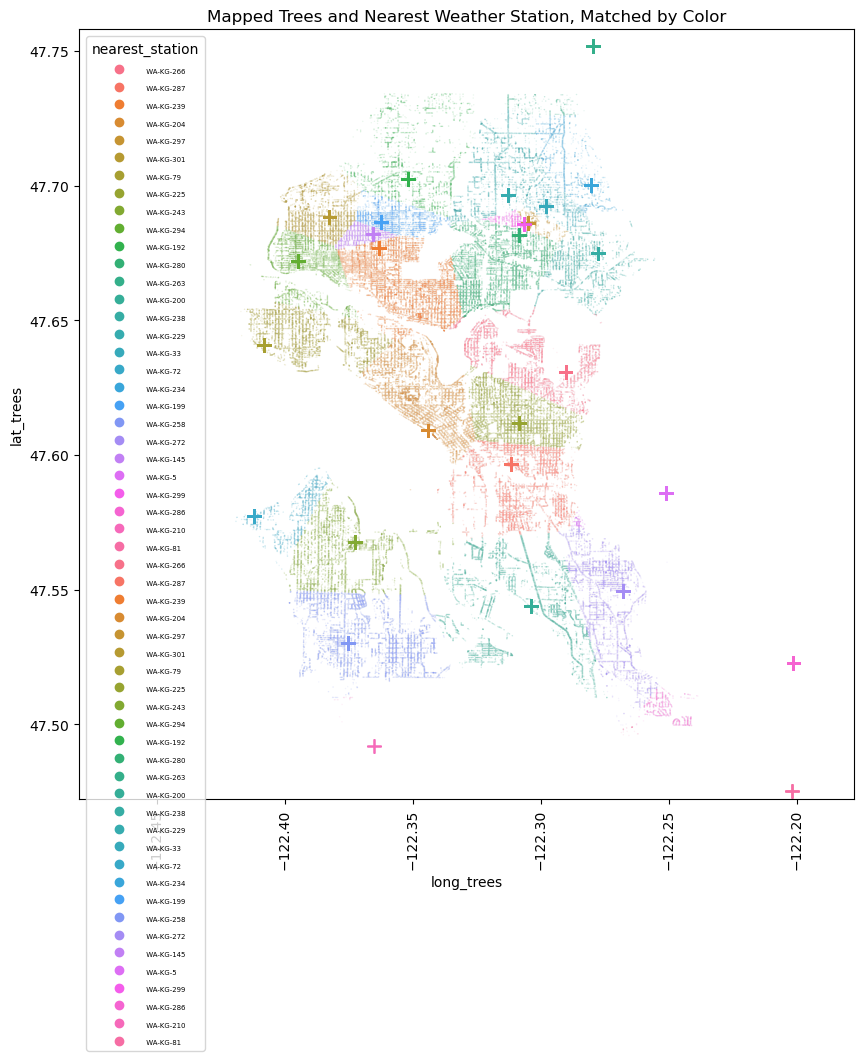

In [20]:
#Create a plot, splitting out the different points by color for their different closest stations and plot them on the same plane as the stations.
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(ax=ax, x='long_trees', y='lat_trees', data=trees_prcp_all, hue='nearest_station', marker='o', s=1, alpha=0.1)
sns.scatterplot(ax=ax, x='long_prcp', y='lat_prcp', data=trees_prcp_all, hue='nearest_station', marker='+', s=100)

#zoom into rough seattle area by adding some space around the min and max values
plt.axis([trees_data['long_trees'].min()*1.0005, trees_data['long_trees'].max()*.9995, trees_data['lat_trees'].min()*0.9995, trees_data['lat_trees'].max()*1.0005])

#set title, change legend font size, and rotate axis labels
ax.set_title('Mapped Trees and Nearest Weather Station, Matched by Color')
plt.setp(ax.get_legend().get_texts(), fontsize='5')
plt.xticks(rotation=90)
plt.show()

**Observations**
\
This isn't the prettiest graph, which such a long legend and no actual underlying map, but it does what I needed and shows the mapping function did work to flag the closest weather station to each tree. There are some some tree-station pair groupings, with the smallest being 26 tree records mapping closest to Burien 2.1 NNW station, I will let these play out as I do more EDA.
\
\
A next question I have is the location to the nearest station. I see some station '+' markers pretty isolated. They may still be the 'closest' but aren't close enough to be fully valuable. We can add another field with distance to the nearest station before moving on to the rest of our more 'traditional' EDA. This will give our data another variable that could prove useful.

##### 3.1.7 Distance Between Points

In [21]:
# Use our handy formula created above on our trees_prcp_all df using list comprehension on each row. This could be a lenghty run so let's see how it goes.

trees_prcp_all['distance_between'] = [dist_b_points(trees_prcp_all.long_trees[i], trees_prcp_all.lat_trees[i]
                                                    , trees_prcp_all.long_prcp[i], trees_prcp_all.lat_prcp[i]) 
                                                    for i in range(len(trees_prcp_all))]

In [22]:
#That actually ran really fast. Let's see how it went.
trees_prcp_all['distance_between'].describe()

count    162080.000000
mean          1.517032
std           0.977325
min           0.004214
25%           0.807316
50%           1.334919
75%           1.988311
max           7.514261
Name: distance_between, dtype: float64

It is a little hard to tell without mapping out a full map, but I know a quarter degree of longitude is around 8.5 miles. Looking at our plot above this appears plausible that the max disstance would be around 7.5km.

In [23]:
#Let's see how that looks in our df
trees_prcp_all.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,station_name,daily_prcp_mm,multi_day_prcp_mm,total_prcp_mm,daily_snow_cm,reports_#,lat_prcp,long_prcp,md_overlap,distance_between
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,Seattle 2.9 ENE,680.0,NaN,680.0,0.0,237,47.630883,-122.290286,NaN,0.947927
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,Seattle 2.9 ENE,680.0,NaN,680.0,0.0,237,47.630883,-122.290286,NaN,3.367105
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,Seattle 2.9 ENE,680.0,NaN,680.0,0.0,237,47.630883,-122.290286,NaN,1.145690


### 3.2 "Traditional" EDA

Now that we have a combined dataframe, let's move on to exploring it further.